# GHS-UCDB
Cascade Tuholske, Spring 2024  

Notebook to find the area-average ten-year average count for heat for the GHS-UCSB. 

In [1]:
# Dependencies 
import numpy as np
import xarray 
import os
import glob
import rasterio
import time
import multiprocessing as mp 
from multiprocessing import Pool
import sys
import matplotlib.pyplot as plt
import rasterstats
import geopandas as gpd
import xarray as xr
from rasterstats import zonal_stats
import matplotlib
import pandas as pd

## Ten year average

In [2]:
def raster_avg(fns, fn_out):
    
    """Average rasters over time
    Args:
        fns = list of tif files to average
        fn_out = path/to/file/out
    """
    
    print(fns[-1])
     
    # Open the files into an Xarray Data Array
    ds = xr.concat([xr.open_dataset(f) for f in fns], dim='band')
    
    # Get the ten year average as an array
    avg = ds.band_data.mean(dim = 'band').data
    
    # write it to disk
    avg = np.nan_to_num(avg, nan = -9999) # fill nan
    meta = rasterio.open(fns[0]).meta # meta data

    with rasterio.open(fn_out, 'w', **meta) as out:
        out.write_band(1, avg)
        
    # clear memory
    del(ds)
    del(avg)
    print('done')

In [4]:
# data out 
ssp = '2050_SSP245' # '2050_SSP245' #'2050_SSP585' 'obs'
data = 'himax'
thresh = '41'

In [5]:
# Select 2007 - 2016 counts
path = '../../../grp-ct/data/processed/CHC-CMIP6/'
fns = sorted(glob.glob(os.path.join(path, 'annual_counts/' + data + '/' + ssp + '*' + thresh + '*.tif')))[24:] # + ssp + thresh + '*.tif')))[24:]
#fns = [f for f in fns if '2050_SSP245' not in f][24:] # filter and get top ten
print(len(fns))
fns

10


['../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2007.tif',
 '../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2008.tif',
 '../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2009.tif',
 '../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2010.tif',
 '../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2011.tif',
 '../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2012.tif',
 '../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2013.tif',
 '../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2014.tif',
 '../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2015.tif',
 '../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2016.tif']

In [8]:
# fn out
fn_out = os.path.join(path, ssp + '.' +data + thresh + '.avg_count_07-16.tif')
print(fn_out)

../../../grp-ct/data/processed/CHC-CMIP6/2050_SSP245.himax41.avg_count_07-16.tif


In [9]:
# run it
raster_avg(fns, fn_out)

../../../grp-ct/data/processed/CHC-CMIP6/annual_counts/himax/2050_SSP245.himax41.count.2016.tif
done


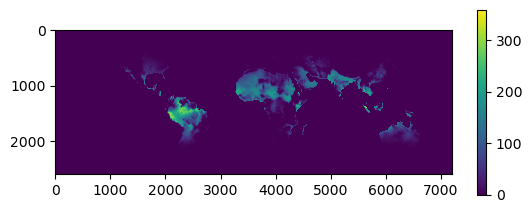

In [10]:
# check the data
data = rasterio.open(fn_out).read(1)
plt.imshow(data, vmin = 0)
plt.colorbar(shrink = 0.5)
plt.show()

## Zonal Stats

In [ ]:
# set up 
ssp = '2050_SSP245' #'2050_SSP585', obs, '2050_SSP245'
col = '2050SSP245' # no _
data = 'Tmax'
thresh = '45'

In [ ]:
# files
path = '../data/processed/CHC-CMIP6/'
fn_in = os.path.join(path, 'CASA/interim/' + ssp + '.' + data + thresh + '.avg_count_07-16.tif')
fn_out = os.path.join(path, 'CASA/interim/' + ssp + '.' + data + thresh + '.avg_count_07-16.shp')

In [ ]:
# Open GHS
ghs_fn = os.path.join('../data/raw/GHS_STAT_UCDB2015MT_GLOBE_R2019A/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
ghs = gpd.read_file(ghs_fn)
ghs.head(1)

In [ ]:
# subset columns needed
polys_in = ghs[['ID_HDC_G0', 'geometry']]
polys_in.head(1)

In [ ]:
# check crs
ghs.crs

In [ ]:
# check crs
rasterio.open(fn_in).crs

In [ ]:
# Run zonal stats
stats_type = 'mean'
zs_feats = zonal_stats(polys_in, fn_in, stats=stats_type, geojson_out=True, all_touched = True)
zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)

In [ ]:
# check the data
plt.hist(zgdf['mean'])

In [ ]:
# rename column
zgdf.rename(columns = {'mean' : col}, inplace = True)
zgdf

In [ ]:
# check nan values
zgdf[zgdf[col].isna()]

In [ ]:
# Save It Out
ghs_out = os.path.join(fn_out) # remove period '.' for Tmax obs
zgdf.to_file(ghs_out, index=False)

# Merge Data Into Single .shp file + csv 

In [ ]:
# Select 2007 - 2016 counts
path = '../data/processed/CHC-CMIP6/'

In [ ]:
# obs = gpd.read_file(os.path.join(path, 'CASA/interim/obs.wbgtmax30.avg_count_07-16.shp'))
# ssp245 = gpd.read_file(os.path.join(path, 'CASA/interim/2050_SSP245.wbgtmax30.avg_count_07-16.shp'))
# ssp585 = gpd.read_file(os.path.join(path, 'CASA/interim/2050_SSP585.wbgtmax30.avg_count_07-16.shp'))
# fn_out = os.path.join(path, 'CASA/processed/wbgtmax30_avg_counts_07-16')

In [ ]:
obs = gpd.read_file(os.path.join(path, 'CASA/interim/obs.Tmax45.avg_count_07-16.shp'))
ssp245 = gpd.read_file(os.path.join(path, 'CASA/interim/2050_SSP245.Tmax45.avg_count_07-16.shp'))
ssp585 = gpd.read_file(os.path.join(path, 'CASA/interim/2050_SSP585.Tmax45.avg_count_07-16.shp'))
fn_out = os.path.join(path, 'CASA/processed/Tmax45_avg_counts_07-16')

In [ ]:
out = pd.merge(obs[['ID_HDC_G0', 'obs']], ssp245[['ID_HDC_G0', '2050SSP245']], on = 'ID_HDC_G0', how = 'inner')
out.head(1)

In [ ]:
out = pd.merge(out, ssp585[['ID_HDC_G0', '2050SSP585']], on = 'ID_HDC_G0', how = 'inner')
out.head(1)

In [ ]:
print(len(obs))
print(len(out))

In [ ]:
gdf_out = gpd.GeoDataFrame(pd.merge(out, obs[['ID_HDC_G0', 'geometry']], on = 'ID_HDC_G0', how = 'inner'))
gdf_out.head(1)

In [ ]:
# shp
gdf_out.to_file(fn_out + '.shp', index = False)

In [ ]:
# csv
gdf_out.drop(columns = 'geometry').to_csv(fn_out + '.csv', index = False)